# 微信数据统计分析

## 导入依赖库

In [3]:
import pickle
import random
import os
from PIL import Image
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from wordcloud import WordCloud
import itchat
from threading import Thread as th
import jieba
import re
import json
from urllib.request import urlopen, quote
import webbrowser as web
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(style="white", context="notebook")
sns.set_style('whitegrid', {'font.sans-serif':['simhei', 'Arial']})

## 登陆微信获取数据

In [2]:
itchat.auto_login()

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as 查永春


## 如果不能登录，则使用本地数据替代

In [4]:
from urllib import request
import pickle

url = 'https://yooongchun-blog-v2.oss-cn-beijing.aliyuncs.com/media/friends.pickle'
file_stream = request.urlopen(url)  # 读取远程数据
friends = pickle.load(file_stream)
print('朋友数：\t', len(friends))

朋友数：	 705


## 保存数据

In [5]:
with open("friends.data","wb")as fp:
    pickle.dump(friends,fp)

## 加载数据

In [2]:
with open("friends.data","rb")as fp:
    friends=pickle.load(fp)

print("Total {} friends.".format(len(friends)))

ModuleNotFoundError: No module named 'itchat'

## 城市数据

In [31]:
pro_city={}
for friend in friends:
    province=friend['Province']
    city=friend['City']
    pc=province+' '+city
    if pc in pro_city:
        pro_city[pc] += 1
    else:
        pro_city[pc] = 1
print(pro_city)

{'北京 东城': 4, '浙江 台州': 1, '上海 徐汇': 6, ' ': 186, '天津 ': 2, '北京 海淀': 27, '江苏 无锡': 3, '上海 黄浦': 4, '云南 临沧': 17, '上海 普陀': 2, '四川 泸州': 1, '上海 静安': 3, '贵州 安顺': 2, '安徽 亳州': 2, '上海 闵行': 49, '上海 ': 18, '上海 金山': 1, '四川 绵阳': 1, '广东 广州': 14, '天津 南开': 2, '浙江 杭州': 10, '广东 深圳': 8, '湖北 武汉': 9, '四川 成都': 14, '浙江 温州': 2, 'SanFrancisco 旧金山': 1, '上海 浦东新区': 14, '山东 济南': 3, '湖南 衡阳': 3, '云南 昆明': 9, '浙江 宁波': 3, 'Styria ': 1, '福建 龙岩': 1, '辽宁 沈阳': 1, '北京 ': 11, '陕西 西安': 5, '北京 朝阳': 18, '北京 大兴': 2, '云南 普洱': 1, '云南 保山': 1, '湖北 宜昌': 2, '山东 烟台': 1, 'Wan Chai ': 1, '江苏 南京': 5, '黑龙江 哈尔滨': 5, '安徽 阜阳': 1, '重庆 江北': 2, '江西 上饶': 2, '浙江 嘉兴': 1, 'California Los Angeles': 1, 'New Jersey Others': 1, '山东 青岛': 6, '湖南 岳阳': 2, 'Offaly ': 1, '江苏 南通': 2, '福建 泉州': 4, '广东 茂名': 2, '山西 太原': 2, '江西 南昌': 2, 'New South Wales Sydney': 1, '江苏 苏州': 2, '福建 漳州': 1, '上海 嘉定': 3, '山东 东营': 1, '浙江 湖州': 3, '福建 福州': 3, '上海 松江': 3, 'Longford ': 1, 'Pennsylvania Pittsburgh': 1, 'Lyon ': 1, 'Illinois Chicago City': 1, '重庆 黔江': 1, '江苏 扬州': 1, '山东 潍坊': 2, '广

## 下载头像

In [26]:
def download_icon(user_name,icon_name):
    img = itchat.get_head_img(userName=user_name)
    with open(icon_name,"wb") as fp:
        fp.write(img)

if not os.path.isdir("img"):
    os.mkdir("img")
t_pool=[]
print('Using multiple threads to download images...')
for index,friend in enumerate(friends):
    t=th(target=download_icon,args=(friend["UserName"],"img/{:0>3d}.jpg".format(index+1)))
    t.start()
    t_pool.append(t)

for index,t in enumerate(t_pool):
    print("\rProcessing：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(friends)*100),end="",flush=True)
    t.join()
print("\nDownload images done.")

Using multiple threads to download images...
Processing：[=================================================================>]100.00%
Download images done.


### 拼接头像

In [9]:
def createImg():
    x = 0
    y = 0
    size=3000
    img_dir=os.path.abspath("img")
    imgs = [os.path.join(img_dir,img) for img in os.listdir(img_dir)]
    random.shuffle(imgs)
    new_img = Image.new('RGBA', (size, size))
    width = int(math.sqrt(size * size / len(imgs)))
    num_line = int(size / width)
    for index,img_path in enumerate(imgs):
        print("\rHandling：["+"="*(index//10)+">]"+"{:.2f}%".format((index+1)/len(imgs)*100),end="",flush=True)
        try:
            img = Image.open(img_path)
        except:
            continue
        img = img.resize((width, width), Image.ANTIALIAS)
        new_img.paste(img, (x * width, y * width))
        x += 1
        if x >= num_line:
            x = 0
            y += 1

    new_img.save("all.png")
    return new_img

im=createImg()
im.show()

Handling：[=================================================================>]100.00%

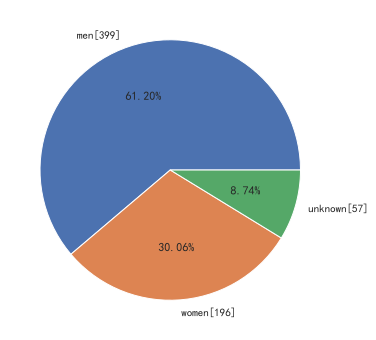

In [24]:
def getSex():
    sex = dict()
    for f in friends:
        if f["Sex"] == 1: # man
            sex["men"] = sex.get("men", 0) + 1
        elif f["Sex"] == 2: # women
            sex["women"] = sex.get("women", 0) + 1
        else: # unknown
            sex["unknown"] = sex.get("unknown", 0) + 1
    return sex
sex=getSex()
df=pd.DataFrame.from_dict(sex,orient="index",columns=["num"])
num=df["num"].values
text=df.index.tolist()
labels=list(map(lambda x: str(x[1])+"["+str(x[0])+"]", zip(num, text)))
plt.figure(figsize=(6,6))
plt.pie(df["num"],labels=labels,autopct="%3.2f%%")
plt.show()

In [29]:
def getSignature():
    with open('sign.txt', 'a', encoding='utf-8') as file:
        for f in friends:
            signature = f["Signature"].strip().replace("emoji", "").replace("span", "").replace("class", "")
            rec = re.compile("1f\d+\w*|[<>/=]")
            signature = rec.sub("", signature)
            file.write(signature + "\n")

def create_word_cloud(filename):
    with open("{}.txt".format(filename), encoding='utf-8') as fp:
        text=fp.read()
    for line in text.split('\n'):
        print(line)
    text=re.sub(r"(\n)+","\n","\n".join(jieba.cut(text))) # 分词
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        font_path='C:\\Windows\\Fonts\\simfang.ttf',
        height=1000,
        width=1000,
        max_font_size=80,
        random_state=50,
    )
    myword = wc.generate(text)
    wc.to_file('signature.png')
    os.system('start signature.png')
getSignature()
create_word_cloud("sign")

读万卷书，行万里路！
稀里糊涂未必不好,,Ծ^Ծ,,

sgjfetifchhfb

爱水果，爱健康，爱生活
最喜欢的告别方式  “明天再见”

揪心！

18811225058
WHY NOT ?


我是一个努力干活，还不黏人的小妖精


像硬汉一样学习和生活。

总是在做事吧~

Diamonds or rust
管好自己
没有陌生人的世界

爱你所爱 行你所行 听从你心 无问西东


Wer die Wahl hat,hat die Qual

翻山越岭，触摸到云

人生就是一段旅程


曾经沧海难为水
除却巫山不是云
法学研究和大数据技术的跨界者。能出成果，出好成果
一定是特别的缘分，才可以一路走来变成一家人
佛着

技术时代的思行者！
为时未晚
衷心诉了春过半，平生光影短。


随风飘散

沧海横流，方显英雄本色。树高万丈不忘根，人若辉煌不忘本！



等待人生的第一笔单




活不过一集，死于话多。
无人为你挡枪口,那就做自己的英雄。
13421849900

是你自恋

玻璃晴朗，橘子辉煌

烦恼会解决烦恼
天天睡不醒
唯愿踏实且勤恳。



让坚持成为一种习惯
专注、沉着、耐心、舍得
生命太短，没时间留给遗憾！！
多年以后。。。。
我的栗子呢🌰
正大方圆
无始心熏染，心如影像般，纵现外境相，如实见境无。
25571765677776765

You mistake stars reflected in a pond for the night sky
简单专注
我遇见谁会有怎样的对白？
春暖花开

机会难得，失去却很容易。
不舍爱与自由
不常在线，有急事直接电话
我就是我



Work hard, play harder！

夏虫不可语冰





无人知晓  偏安一隅


昨夜星辰昨夜风。

幸福并感激着

我叫阮钦

永结无情游，相期邈云汉

KEEP TRYING. PLAY AROUND.

丧
太阳公公出来了
不念过往，不畏将来

请先说你好


我在这里啊。
都来找我玩
做好当前
开心就好！
1124


keep your spirit soaring high
日啖鱼干三百斤，不辞长做喵星人a

生活是苦难的，我又划着我的断桨出发了

英雄也投降
桃栗三年柿八年 达摩九年我一生

学习一个
不好好学习你就是狗！
？？？
开心就好

In [37]:

# 根据地名获得经纬度信息
def GetLngLat(address):
    url = 'http://api.map.baidu.com/geocoder/v2/'
    output = 'json'
    ak = 'x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1'
    add = quote(address)
    uri = url + '?' + 'address=' + add + '&output=' + output + '&ak=' + ak
    try:
        req = urlopen(uri)
    except ConnectionRefusedError as e:
        return e
    res = req.read().decode()
    temp = json.loads(res)  # 对json数据进行解析
    return temp

# 可视化热力图html代码
def html_code():
    head = '''<!DOCTYPE html>\n<html>\n<head>\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n    <meta name="viewport" content="initial-scale=1.0, user-scalable=no" />\n    <script type="text/javascript" src="http://gc.kis.v2.scr.kaspersky-labs.com/C8BAC707-C937-574F-9A1F-B6E798DB62A0/main.js" charset="UTF-8"></script><script type="text/javascript" src="http://api.map.baidu.com/api?v=2.0&ak=x2ZTlRkWM2FYoQbvGOufPnFK3Fx4vFR1"></script>\n    <script type="text/javascript" src="http://api.map.baidu.com/library/Heatmap/2.0/src/Heatmap_min.js"></script>\n    <title>热力图功能示例</title>\n    <style type="text/css">\n		ul,li{list-style: none;margin:0;padding:0;float:left;}\n		html{height:100%}\n		body{height:100%;margin:0px;padding:0px;font-family:"微软雅黑";}\n		#container{height:500px;width:100%;}\n		#r-result{width:100%;}\n    </style>	\n</head>\n<body>\n	<div id="container"></div>\n	<div id="r-result">\n		<input type="button"  onclick="openHeatmap();" value="显示热力图"/><input type="button"  onclick="closeHeatmap();" value="关闭热力图"/>\n	</div>\n</body>\n</html>\n<script type="text/javascript">\n    var map = new BMap.Map("container");          // 创建地图实例\n\n    var point = new BMap.Point(105.418261, 35.921984);\n    map.centerAndZoom(point, 5);             // 初始化地图，设置中心点坐标和地图级别\n    map.enableScrollWheelZoom(); // 允许滚轮缩放\n  \n    var points =['''
    rear = ''']\n   \n    if(!isSupportCanvas()){\n    	alert('热力图目前只支持有canvas支持的浏览器,您所使用的浏览器不能使用热力图功能~')\n    }\n	//详细的参数,可以查看heatmap.js的文档 https://github.com/pa7/heatmap.js/blob/master/README.md\n	//参数说明如下:\n	/* visible 热力图是否显示,默认为true\n     * opacity 热力的透明度,1-100\n     * radius 势力图的每个点的半径大小   \n     * gradient  {JSON} 热力图的渐变区间 . gradient如下所示\n     *	{\n			.2:'rgb(0, 255, 255)',\n			.5:'rgb(0, 110, 255)',\n			.8:'rgb(100, 0, 255)'\n		}\n		其中 key 表示插值的位置, 0~1. \n		    value 为颜色值. \n     */\n	heatmapOverlay = new BMapLib.HeatmapOverlay({"radius":20});\n	map.addOverlay(heatmapOverlay);\n	heatmapOverlay.setDataSet({data:points,max:10});\n	//是否显示热力图\n    function openHeatmap(){\n        heatmapOverlay.show();\n    }\n	function closeHeatmap(){\n        heatmapOverlay.hide();\n    }\n	openHeatmap();\n    function setGradient(){\n     	/*格式如下所示:\n		{\n	  		0:'rgb(102, 255, 0)',\n	 	 	.5:'rgb(255, 170, 0)',\n		  	1:'rgb(255, 0, 0)'\n		}*/\n     	var gradient = {};\n     	var colors = document.querySelectorAll("input[type='color']");\n     	colors = [].slice.call(colors,0);\n     	colors.forEach(function(ele){\n			gradient[ele.getAttribute("data-key")] = ele.value; \n     	});\n        heatmapOverlay.setOptions({"gradient":gradient});\n    }\n	//判断浏览区是否支持canvas\n    function isSupportCanvas(){\n        var elem = document.createElement('canvas');\n        return !!(elem.getContext && elem.getContext('2d'));\n    }\n</script>'''

    return head, rear
def view_map(pro_city):
    # 显示城市分布,使用百度的api获得相应城市的经纬度，然后使用heatmap.json生成热力图，返回html文件
    json_data = ''
    # 把城市数据转为经纬度
    for city, value in pro_city.items():
        try:
            pos = GetLngLat(city)
        except ConnectionError:
            pos = None
        if pos is not None and pos['status'] == 0:
            lng = pos['result']['location']['lng']
            lat = pos['result']['location']['lat']
            json_temp = '{"lng":' + str(lng) + ',"lat":' + str(lat) + ', "count":' + str(value) + '}, '
            json_data += '\n' + json_temp

    # 生成html格式热力图文件
    try:
        head, rear = html_code()
        html_file = head + json_data + rear
        with open('heatmap.html', 'w', encoding='utf-8') as f:
            f.write(html_file)
            # 网页显示
            web.open('heatmap.html', new=0, autoraise=True)
    except AttributeError:
        return AttributeError

view_map(pro_city)